### Reimplementation (in Torch) of a 100-Line char-RNN Written by Karpathy (in Numpy)
Code: https://gist.github.com/karpathy/d4dee566867f8291f086


In [1]:
from char_rnn_karpathy_in_torch import RNNCell, SequentialDataGenerator

In [2]:
data_gen = SequentialDataGenerator("data/shakespear.txt")
rnn = RNNCell(100, data_gen)

In [3]:
rnn.train(2000, learning_rate=0.01, checkpoint_range=500)

Data size: 4573337; Vocab Size: 67
Iteration 0; loss: 22.961233139038086
Iteration 500; loss: 6.915727615356445
Iteration 1000; loss: 3.9106833934783936
Iteration 1500; loss: 5.252096176147461


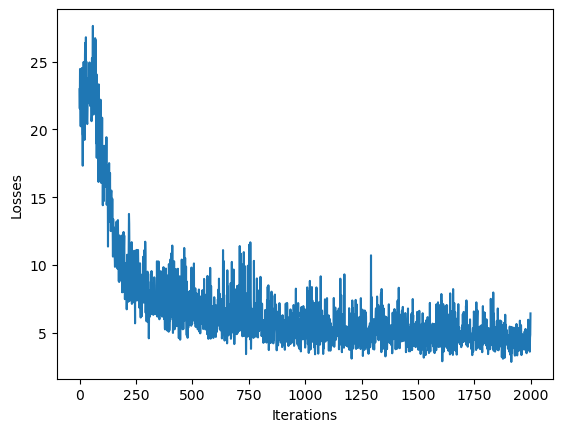

In [4]:
rnn.plot_losses()